In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Real data

In [85]:
# Loading the data from the traffic dataset

referential_data = pd.read_csv("../data/referentiel-comptages-routiers.csv", sep=";")
historical_data  = pd.read_csv("../data/comptages-routiers-permanents.csv" , sep=";")
str_arcs = historical_data['Identifiant arc'].astype("str")
entrees_abberrantes = historical_data[(str_arcs > "999") | (str_arcs < "0")].copy()
historical_data.drop(entrees_abberrantes.index, inplace=True)
historical_data['Identifiant arc'] = historical_data['Identifiant arc'].astype("int")
historical_data["Date et heure de comptage"] = pd.to_datetime(historical_data["Date et heure de comptage"])

c:\Users\leobu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


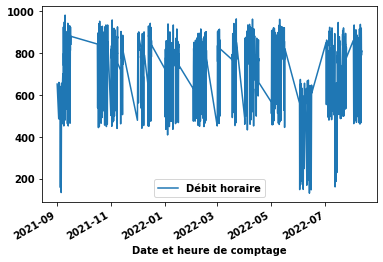

In [86]:
# Time series of one arc
my_arc = historical_data[historical_data["Identifiant arc"] == 6451].sort_values("Date et heure de comptage").dropna()
real_y = my_arc["Débit horaire"]
real_x = my_arc["Date et heure de comptage"]
#plt.plot(real_y.to_numpy())
my_arc.plot("Date et heure de comptage", "Débit horaire")

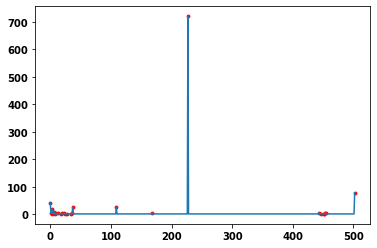

In [127]:
# Study of the discontinuity (in hours)
diff = real_x.diff().apply(lambda timedelta : timedelta.total_seconds()/3600).iloc[1:]
interest = diff.to_numpy()[:503]
plt.plot(interest)
plt.scatter(np.arange(interest.shape[0])[interest != 1], interest[interest != 1], c="r", s=8)

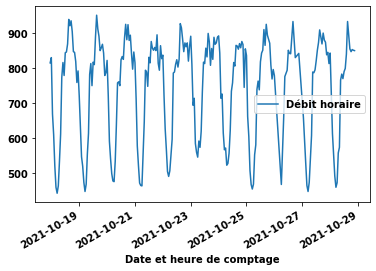

In [128]:
# An "almost" continuous part of the time series
my_arc2 = my_arc.iloc[250:500]
real_y2 = my_arc2["Débit horaire"]
real_x2 = my_arc2["Date et heure de comptage"]
#plt.plot(real_y.to_numpy())
my_arc2.plot("Date et heure de comptage", "Débit horaire")

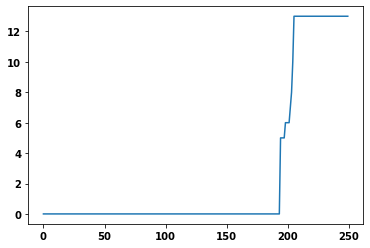

In [158]:
# Cumulative discontinuity on this part of the time series (in hours)

# unintermit = np.arange(real_x2.iloc[0], real_x2.iloc[0] + datetime.timedelta(hours=len(real_x2)), datetime.timedelta(hours=1))
unintermit = np.array([real_x2.iloc[0] + datetime.timedelta(hours=i) for i in range(len(real_x2))])
to_hours = np.vectorize(lambda timedelta : timedelta.total_seconds()/3600)
plt.plot(to_hours(real_x2.to_numpy() - unintermit))

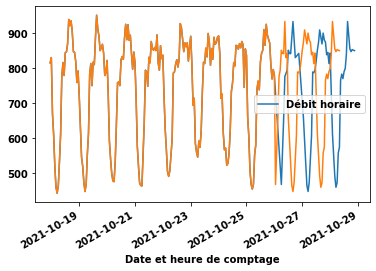

In [159]:
# Discrepancy between the real data and the data considering one hour between each datum.

my_arc2.plot("Date et heure de comptage", "Débit horaire")
plt.plot(unintermit, real_y2)

# Toy data

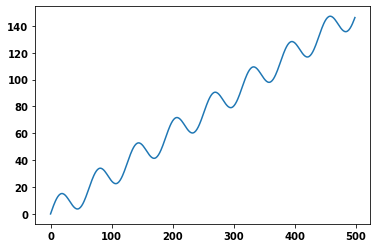

In [2]:
# T = 500
# t = np.arange(T)
# n_lag = 50
# t_full = np.arange(-n_lag, T)
# w_true = 0.1

# y1_full = t_full.copy()
# x1_lag = np.array([y1_full[i:i+n_lag] for i in range(T)]).T
# x1_time = np.array([t] + [np.sin(0.4*r*w_true*t) for r in range(7)] + [np.cos(0.4*r*w_true*t) for r in range(7)]).T
# y1 = np.arange(T)

# y2_full = 1/w_true*np.sin(w_true*t_full) + 0.3*t_full
# x2_lag = np.array([y2_full[i:i+n_lag] for i in range(T)]).T
# x2_time = x1_time.copy()
# y2 = y2_full[n_lag:]
# plt.plot(t, y2)
# plt.show()

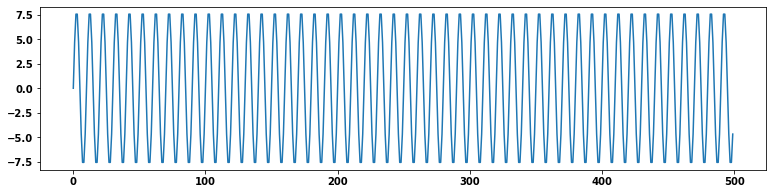

In [160]:
# A toy time series (sum of sinusoids)

T = 500
t = np.arange(T)

w0 = 0.1*2*np.pi
w1 = 0.01*2*np.pi
y = 0/w1*np.sin(w1*t)+5/w0*np.sin(w0*t)
plt.figure(figsize=(13,3))
plt.plot(t, y)
plt.show()

# Models

In [39]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, horizon_size):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.RNN(input_dim, hidden_dim,batch_first=True)
        self.decoder = nn.RNN(input_dim, hidden_dim,batch_first=True)
        self.outputise = nn.Linear(hidden_dim, input_dim)
        # with batch first= True, inputs and outputs have size (batch_size, seq_size, n_features)
        self.hor = horizon_size #integer
    
    def forward(self, x):
        """
        x : size (batch_size, seq_size, n_features)
        """
        # x is a batch of known sequences
        # returns a batch of predicted sequences of size self.hor
        h0 = torch.rand((1,x.size(0), self.hidden_dim)).requires_grad_() #x.size(0) is the batch size
        _, hn = self.encoder(x, h0.detach())

        # Deconding phase. We take the output as the input of the next time step
        output = torch.zeros(x.size(0), self.hor, x.size(2)) # Will contain all the outputs
        x_in = x[:,[-1],:]
        h_in = hn
        for t in range(self.hor):
            out, h_out = self.decoder(x_in, h_in) # out has size : batch_size, seq_size (=1), hidden_dim
            x_out = self.outputise(out) # size batch_size, seq_size (=1), input_dim
            output[:,t,:] = x_out[:,0,:] #size batch_size, input_dim
            x_in = x_out.clone() #copy() #size batch_size, seq_size (=1), input_dim
            h_in = h_out
        
        return output
    


In [40]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, horizon_size):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.LSTM(input_dim, hidden_dim,batch_first=True)
        self.decoder = nn.LSTM(input_dim, hidden_dim,batch_first=True)
        self.outputise = nn.Linear(hidden_dim, input_dim)
        # with batch first= True, inputs and outputs have size (batch_size, seq_size, n_features)
        self.hor = horizon_size #integer
    
    def forward(self, x):
        """
        x : size (batch_size, seq_size, n_features)
        """
        # x is a batch of known sequences
        # returns a batch of predicted sequences of size self.hor
        h0 = torch.rand((1,x.size(0), self.hidden_dim)).requires_grad_() #x.size(0) is the batch size
        c0 = torch.rand((1,x.size(0), self.hidden_dim)).requires_grad_() #x.size(0) is the batch size
        _, (hn, cn) = self.encoder(x, (h0.detach(), c0.detach()))

        # Deconding phase. We take the output as the input of the next time step
        output = torch.zeros(x.size(0), self.hor, x.size(2))
        x_in = x[:,[-1],:]
        h_in = hn
        c_in = cn
        for t in range(self.hor):
            out, (h_out, c_out) = self.decoder(x_in, (h_in, c_in)) #out has size : batch_size, seq_size (=1), hidden_dim
            x_out = self.outputise(out) # size batch_size, seq_size (=1), input_dim
            output[:,t,:] = x_out[:,0,:] #size batch_size, input_dim
            x_in = x_out.clone() #copy() #size batch_size, seq_size (=1), input_dim
            h_in = h_out
            c_in = c_out
        
        return output
    


# Parameters and preparation

In [161]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 1e-3
batch_size = 30
epochs = 5
weight_decay = 1e-6

horizon = 5

In [177]:
model = LSTMModel(1,5,horizon) #RNNModel(1, 5, horizon)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=weight_decay) #?

In [178]:
y_normalised = (y - y.mean())/y.std()
data_train, data_test = y_normalised[:250], y_normalised[250:]

len_small_ts = 50 # Length of the series we will give as food to the model (length of window)

def to_XY(time_series, horizon, len_small_ts):
    X = np.zeros((len(time_series) - horizon - len_small_ts + 1, len_small_ts))
    Y = np.zeros((len(time_series) - horizon - len_small_ts + 1, horizon))
    for i in range(X.shape[0]):
        X[i] = time_series[i : i+len_small_ts]
        Y[i] = time_series[i+len_small_ts : i+len_small_ts+horizon]
    return X[:,:,None], Y[:,:,None]

X_train, Y_train = to_XY(data_train, horizon, len_small_ts)
X_test, Y_test = to_XY(data_test, horizon, len_small_ts)

X_train = torch.from_numpy(X_train).float()
X_test  = torch.from_numpy(X_test ).float()
Y_train = torch.from_numpy(Y_train).float()
Y_test  = torch.from_numpy(Y_test ).float()


train = TensorDataset(X_train, Y_train)
test = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
#test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

# Training

In [179]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for i_batch, (X, y) in enumerate(dataloader):        
        # Compute prediction and loss
        X = X.to(device) #?
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad() #?
        loss.backward()
        optimizer.step()

        if i_batch % 1 == 0:
            loss, current = loss.item(), i_batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= size
    correct /= size
    print(f"Test Error: \nAvg loss: {test_loss:>8f} \n")


In [180]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.272178  [    0/  196]
loss: 1.268016  [   30/  196]
loss: 1.263900  [   60/  196]
loss: 1.259829  [   90/  196]
loss: 1.255803  [  120/  196]
loss: 1.251824  [  150/  196]
Test Error: 
Avg loss: 0.038201 

Epoch 2
-------------------------------
loss: 1.247890  [    0/  196]
loss: 1.244002  [   30/  196]
loss: 1.240158  [   60/  196]
loss: 1.236358  [   90/  196]
loss: 1.232601  [  120/  196]
loss: 1.228887  [  150/  196]
Test Error: 
Avg loss: 0.037507 

Epoch 3
-------------------------------
loss: 1.225215  [    0/  196]
loss: 1.221584  [   30/  196]
loss: 1.217995  [   60/  196]
loss: 1.214445  [   90/  196]
loss: 1.210935  [  120/  196]
loss: 1.207464  [  150/  196]
Test Error: 
Avg loss: 0.036858 

Epoch 4
-------------------------------
loss: 1.204030  [    0/  196]
loss: 1.200634  [   30/  196]
loss: 1.197273  [   60/  196]
loss: 1.193947  [   90/  196]
loss: 1.190656  [  120/  196]
loss: 1.187397  [  150/  196]
Test Error: 
Avg l

# Results

In [181]:
model.eval()
Y_train_pred = model(X_train)

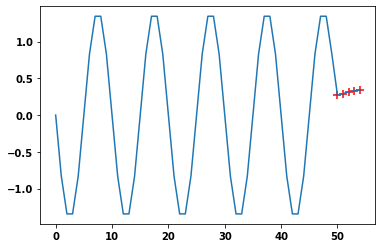

In [197]:
i_test = 5
# plt.plot(np.arange(i_test,i_test+len_small_ts), X_train[i_test].detach())
plt.plot(np.concatenate((X_train[i_test].detach().numpy(), Y_train_pred[i_test].detach().numpy())))
plt.scatter(np.arange(len_small_ts, len_small_ts + horizon), Y_train_pred[i_test].detach(), marker="+", c="r", s=64)

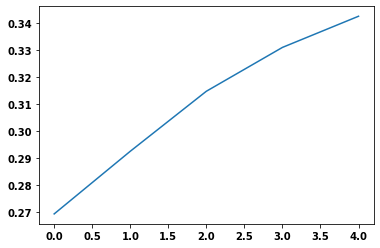

In [187]:
plt.plot(Y_train_pred[i_test].detach().numpy())

In [184]:
# Comparison with linear regression

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train[:,:,0], Y_train[:,:,0])
Y_rl_pred = linreg.predict(X_test[:,:,0])
Y_rl_pred.shape


(196, 5)

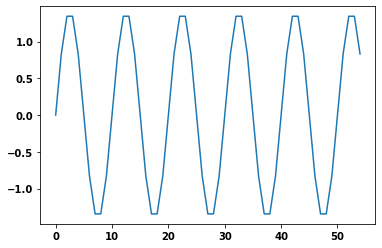

In [185]:
plt.plot(np.concatenate((X_test[0,:,0].detach().numpy(), Y_rl_pred[0])))